In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# We are working on this project in google colab, hence the pip install
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.9 MB/s 
     |████████████████████████████████| 280 kB 82.0 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [3]:
# Import the related libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import random
import dgl
import torch 
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from numpy.linalg import norm
from dgl.nn.pytorch import conv as dgl_conv
from dgl.nn.pytorch.glob import SumPooling
import warnings
warnings.filterwarnings('ignore')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
# Importing the training data
csv_pds = []
dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31"):
    if file.endswith(".csv"):
        csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31/"+file,on_bad_lines="skip"))
        dates.append(file[0:8])

In [5]:
# Preprocessing of our data
# Since the covid data we obtain from the HK gov website has some minor typo in their district names,
# we use a sequence matcher to match the closest name to the district defined in the districts array
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter)
  iter +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [6]:
series_count_district ={}
for district in districts:
    series_count_district[district] = []

In [7]:
day =0
for pd in csv_pds:
    for district in districts:
          series_count_district[district].append((pd['District'] == district).sum())

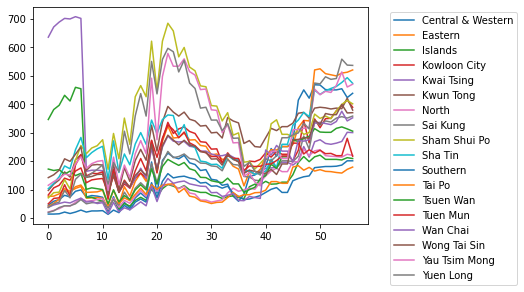

In [8]:
# Plot the series_count_district data to have an overview 
for district in series_count_district:
    plt.plot(series_count_district[district], label=district)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [9]:
# Creating the pearson correlation matrix
district_series = []
for district in districts:
  district_series.append(series_count_district[district])
correlation = np.corrcoef(district_series, district_series)
useful_correlation = correlation[0:18,0:18]

In [10]:
# Our Graph Sage model
class COVID_GraphSage(nn.Module):
  def __init__(self, in_feats, n_hidden, out_dim,activation,dropout,aggregator_type='mean',n_layers=2):
    super(COVID_GraphSage, self).__init__()
    self.layers = nn.ModuleList()
    #input layer 
    self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type, feat_drop=dropout, activation=activation))
    
    #hidden layers 
    for i in range(n_layers-1):
      self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type, feat_drop=dropout, activation=activation))
    
    #output_layer
    self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type, feat_drop=dropout, activation=None))
  
    self.d2_pool =(nn.MaxPool1d(1, stride=6))
    # produces 6*6
    self.d1_pool = ( nn.MaxPool1d(1,stride=4))
    
  # returns an 18*1
  def forward(self, g, features):
    h = features
    for layer in self.layers:
      h = layer(g, h)
    h = self.d2_pool(h)
    h = self.d1_pool(h)
    return h

In [11]:
# Creating the sliding window as training data
window_size = 5 
input_dim = (18,4) #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 

modified_input = []
modified_val = []

for sequence in district_series:
    input_sequence = [sequence[i:i+window_size-1] for i in range(0,len(sequence)-5)]
    val_sequence = [[sequence[i+window_size-1] for i in range(0,len(sequence)-5)]]
    modified_input.append(input_sequence)
    modified_val.append(np.array(val_sequence))

modified_input = np.array(modified_input)
modified_val=  np.array(modified_val)
modified_val = modified_val.reshape(18,-1,1)
modified_input =np.array([modified_input[:,x,:] for x in range(len(sequence)-5)])
modified_val = np.array([modified_val[:,x,:] for x in range(len(sequence)-5)])

In [12]:
# Classes and functions to train and evaluate our model
# Our evaluation method is based on Symmetric mean absolute percentage error (SMAPE)
# More details on https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
class COVID_Sage_Case(nn.Module):
  def __init__(self, COVID_Sage_Model, n_hidden):
    super(COVID_Sage_Case, self).__init__()
    self.COVID_Sage_Model = COVID_Sage_Model 
    self.loss_fcn = torch.nn.MSELoss()

  def forward(self, g, features, label):
    features = torch.tensor(features, dtype=torch.double)
    logits = self.COVID_Sage_Model(g, features)
    return self.loss_fcn(logits.double(), label.double())

def COVID_Evaluate(model, g, features, labels):
  model.eval()
  with torch.no_grad():
    logits = model.COVID_Sage_Model(g, features)
    logits = logits.reshape(18)
    labels = labels.reshape(18)
    acc = np.sum(2*np.abs(np.array(logits)-np.array(labels))/(np.abs(np.array(logits))+np.abs(np.array(labels))))/18
  return acc, np.array(logits)
def Train(model, graph, features, labels, n_epochs, optimizer):
  for epoch in range(n_epochs):
    model.train()
    acc =0
    for i in range(features.shape[0]):
      x = torch.tensor(features[i], dtype=torch.double)
      y = torch.tensor(labels[i], dtype=torch.double)
      loss = model(graph,x,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      acc,forecast = COVID_Evaluate(model, graph, x, y)
  return acc
    
def Test(model, graph, features, labels):
  result,forecast = COVID_Evaluate(model, graph, features, labels)
  print("Testing Accuracy:",result)
  return result,forecast

In [13]:
# Reset the seed to a fixed value such the whenever we rerun the block, it wouldn't incur randomness
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device = torch.device('cuda')
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()
torch.use_deterministic_algorithms(True)

weight_decay = 5e-3
n_epochs = 150
lr = 1e-3

thresholds = list(i for i in [float(j) / 100 for j in range(0, 100, 1)])
accuracy_results = [0] * 100
models = []

n_layers = 2
n_hidden = 10
window_size = 5 
input_dim = (18,4) # Past 4 historic cases for all nodes
output_dim = 18    # Covid case prediction for each nodes 
dropout=0.5
# Fifth value is the true value to compare, ie validation

# Iterating the different threshold to create the corersponding adjacency matrix
for i in range(100):
  print(f"Iteration {i}")
  threshold = thresholds[i]
  adjacency_matrix = np.where(useful_correlation > threshold ,1, 0)
  r,c = np.nonzero(adjacency_matrix==1)
  
  covid_graph = dgl.graph((r,c),num_nodes=18)
  covid_graph.ndata['cases'] = torch.ones(covid_graph.num_nodes(),4)
  
  COVID_Sage_Model = COVID_GraphSage(in_feats=(4), n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout)

  model = COVID_Sage_Case(COVID_Sage_Model,n_hidden)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  modified_val = modified_val.astype('double')
  modified_input = modified_input.astype('double')
  model = model.double()
  accuracy_results[i] = Train(model,graph=covid_graph,features=torch.tensor(modified_input), labels=torch.tensor(modified_val),n_epochs=n_epochs, optimizer=optimizer)
  models.append(model)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

[0.054268752580132, 0.06448454612674896, 0.055293909642806297, 0.06515637994046988, 0.06567676923318219, 0.06987296172761824, 0.060969671696597776, 0.0669500087313672, 0.07944965595569761, 0.06867759559764343, 0.06280424097380806, 0.06746994993396296, 0.06163446085547787, 0.06887217987006998, 0.06157852524499183, 0.06113997549291425, 0.061040709205741145, 0.06820669202665083, 0.05922956404622486, 0.09716036333218743, 0.07440515917384495, 0.05849252831060815, 0.06627672418305386, 0.0737294720760872, 0.08078115705950975, 0.0705239366714551, 0.09423689745520908, 0.06744257646514423, 0.05935602630687382, 0.058598400185133265, 0.06841500696187569, 0.0727375556678019, 0.09611341930547312, 0.06557061581293931, 0.0666137517677298, 0.06320869126623499, 0.0587413386761039, 0.06086544827113592, 0.06912860246805387, 0.05418782741522568, 0.06619664642058433, 0.06036623795733807, 0.08780379487362538, 0.07060473137755686, 0.0528549460308583, 0.059123397217599655, 0.0588919989129398, 0.077268974256095

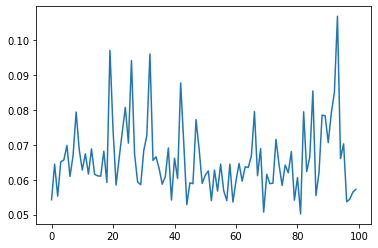

In [14]:
# View the SMAPE value of the model by alternating different value of threshold
min_value = min(accuracy_results)
min_index = accuracy_results.index(min_value)
plt.plot(accuracy_results)
print(accuracy_results)
print(f"Best threshold is {thresholds[min_index]} with the SMAPE of {min_value}")

In [15]:
# Savings the model
for i in range(len(models)):
  torch.save(models[i].state_dict(), f"/content/drive/MyDrive/COMP 4222/thresholds/model_threshold_{thresholds[i]}")